In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from grn_benchmark.src.helper import plot_heatmap, DATASETS, METHODS
from task_grn_inference.src.utils.config import METRICS
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', None)

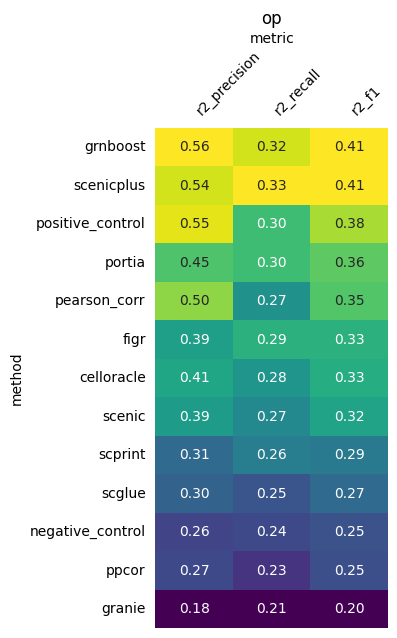

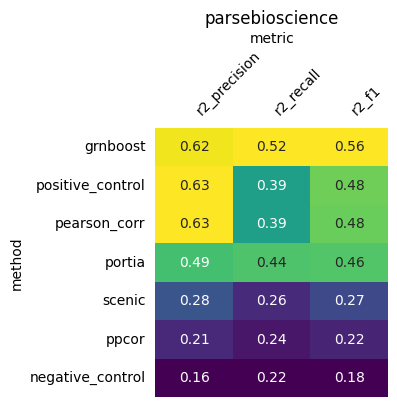

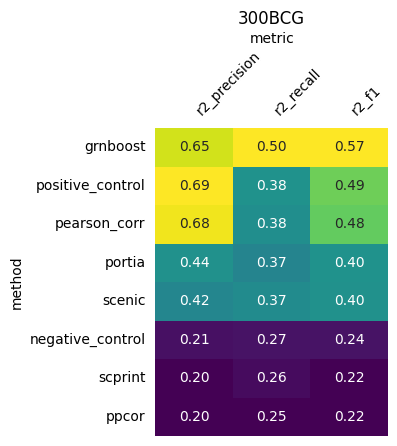

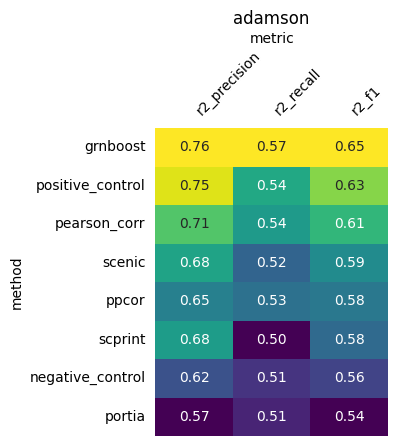

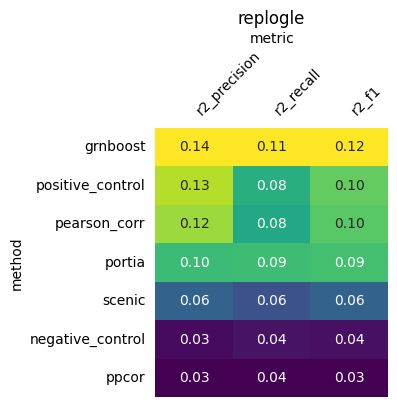

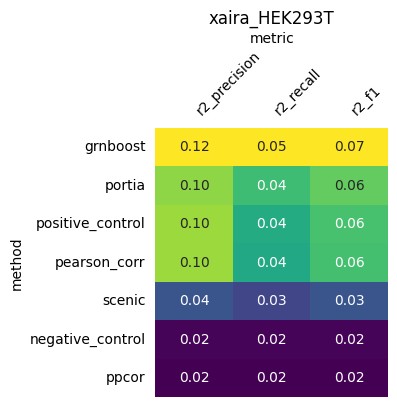

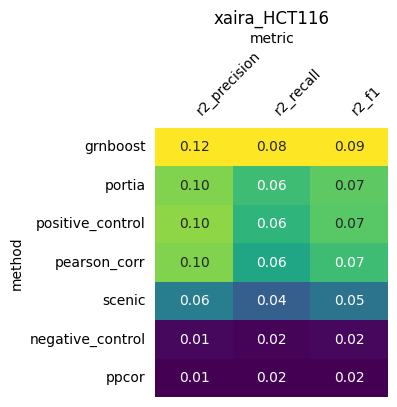

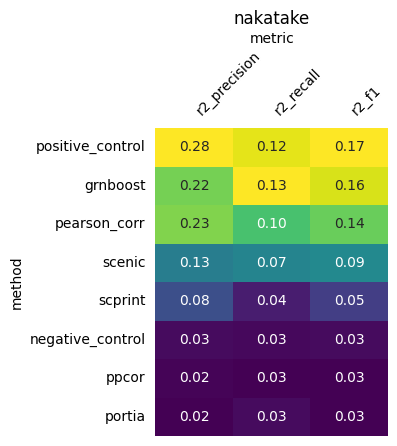

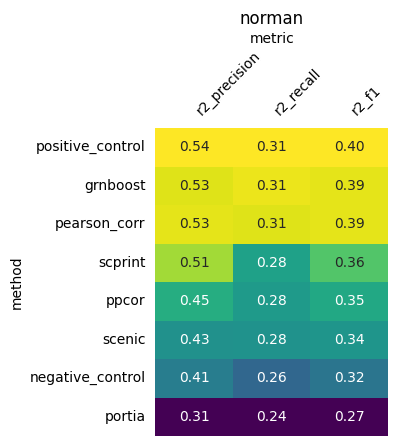

In [3]:
# !ls -lt output/rc_tf_act/
metric = 'regression'

df = pd.read_csv(f'output/{metric}/summary.csv')
for dataset in df['dataset'].unique():
    df_subset = df[df['dataset'] == dataset]
    try:
        df_subset = df_subset.pivot(index='method', columns='metric', values='value')
    except:
        df_subset = df_subset.set_index('method').drop(columns=['dataset'])
    df_subset = df_subset[[c for c in METRICS if c in df_subset.columns]]
    for col in df_subset.columns:
        if 'f1' in col:
            df_subset.sort_values(col, ascending=False, inplace=True)
            break
    else:
        df_subset.sort_values(df_subset.columns[0], ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(1*len(df_subset.columns), .5*len(df_subset)))
    plot_heatmap(df_subset, name='',  cmap="viridis", ax=ax)
    plt.title(f'{dataset}')

# Assemble the results from differnet runs

In [ ]:
!rm -r resources/results/all_main/

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
from collections import OrderedDict

base_dir = 'resources/results/'
save_dir = 'resources/results/all_main/'
runs = ['op', 'nakatake', 'norman', 'replogle', 'adamson']

os.makedirs(save_dir, exist_ok=True)

# 1. Copy one version of the identical files
identical_files = ['method_configs.yaml', 'metric_configs.yaml']
for fname in identical_files:
    src = os.path.join(base_dir, f'{runs[0]}_run', fname)
    dst = os.path.join(save_dir, fname)
    shutil.copyfile(src, dst)
    print(f"Copied identical file: {fname}")

# 2. Merge dataset_uns.yaml by appending all contents
merged_uns = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'dataset_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        merged_uns.extend(data)
        
with open(os.path.join(save_dir, 'dataset_uns.yaml'), 'w') as f:
    yaml.dump(merged_uns, f)
print("Merged: dataset_uns.yaml")

# 3. Merge score_uns.yaml similarly
merged_scores = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'score_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        # - remove those with missing (because of the metric)
        data = [d for d in data if d is not None and 'missing' not in str(d)]
        
        # print(str(data[0]))
        # aa
        # missing
        if data:
            if isinstance(data, dict):
                merged_scores.append(data)
            elif isinstance(data, list):
                merged_scores.extend(data)
            else:
                print(f"Unexpected format in {path}: {type(data)}")

with open(os.path.join(save_dir, 'score_uns.yaml'), 'w') as f:
    yaml.dump(merged_scores, f)
print("Merged: score_uns.yaml")

# 4. Merge trace.txt with deduplication
seen_lines = OrderedDict()
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'trace.txt')
    
    with open(path, 'r') as f:
        for line in f:
            seen_lines[line] = None

with open(os.path.join(save_dir, 'trace.txt'), 'w') as f:
    for line in seen_lines.keys():
        f.write(line)
df = pd.read_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
df = df.drop_duplicates(subset=['name'])
df.to_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
print("Merged: trace.txt (duplicates removed)")

# 5. Copy other unknown files/directories
all_known = set(identical_files + ['dataset_uns.yaml', 'score_uns.yaml', 'trace.txt'])

for run in runs:
    run_dir = Path(base_dir) / f'{run}_run'
    for file_path in run_dir.iterdir():
        if file_path.name in all_known:
            continue

        dest_path = Path(save_dir) / file_path.name

        if dest_path.exists():
            dest_path = Path(save_dir) / f"{file_path.stem}_{run}{file_path.suffix}"

        if file_path.is_file():
            shutil.copyfile(file_path, dest_path)
            print(f"Copied unique file: {file_path.name} → {dest_path.name}")
        elif file_path.is_dir():
            shutil.copytree(file_path, dest_path)
            print(f"Copied unique directory: {file_path.name} → {dest_path.name}")

Copied identical file: method_configs.yaml
Copied identical file: metric_configs.yaml
Merged: dataset_uns.yaml
Merged: score_uns.yaml
Merged: trace.txt (duplicates removed)
Copied unique file: state.yaml → state.yaml
Copied unique file: op_.celloracle.celloracle.prediction.h5ad → op_.celloracle.celloracle.prediction.h5ad
Copied unique file: scplus_mdata.h5mu.2DAaAA8E → scplus_mdata.h5mu.2DAaAA8E
Copied unique file: op_.negative_control.negative_control.prediction.h5ad → op_.negative_control.negative_control.prediction.h5ad
Copied unique file: op_.scenicplus.scenicplus.prediction.h5ad → op_.scenicplus.scenicplus.prediction.h5ad
Copied unique file: op_.portia.portia.prediction.h5ad → op_.portia.portia.prediction.h5ad
Copied unique file: op_.granie.granie.prediction.h5ad → op_.granie.granie.prediction.h5ad
Copied unique file: op_.scprint.scprint.prediction.h5ad → op_.scprint.scprint.prediction.h5ad
Copied unique file: op_.pearson_corr.pearson_corr.prediction.h5ad → op_.pearson_corr.pearso